# Demo of Ch2. Linear Classifier
----
This is the sample code of TU-ETP-AD1062 Machine Learning Fundamentals.

For more information, please refer to:
https://sites.google.com/view/tu-ad1062-mlfundamentals/

## Import packages
----
- `numpy`: Provide linear algebra related computation ability, with `norm` used to measure the l2-norm of matrices and vectors
- `sklearn`: Scikit-Learn, provides basic data analysis and machine learning methods functionality
- `mlfund`:
    - `dataset`: Used to generate data in normal distribution
    - `Plot2D`: Used to plot the figure, implemented by using `matplotlib`


In [1]:
import numpy as np
from numpy.linalg import norm 

import sklearn.metrics
import sklearn.svm
import sklearn.linear_model

from mlfund.dataset import Gaussian, GaussianParam
from mlfund.plot import Plot2D

%matplotlib inline

## 2.2. Perceptron

### Demo 2.2.1. Implement Perceptron Algorithm by the Simplest Gradient Descent
----
#### Perceptron Algorithm Implementation
The demo here shows how to use the simplest gradient descent (which leverages fixed learning rate `self._mu`) to implement Perceptron algorithm. Here's the method details:
##### `__delta_x(self, X_augmented, y)`:  
For each augmented sample $\mathbf{x}$ stored in `X_augmented`, denotes each wrongly classified sample $\mathbf{x}\in Y$ by $\delta_{\mathbf{x}}$ defined as following:
$$
\delta_{\mathbf{x}}=\left\{
    \begin{array}{ll}
      -1, \text{if } \mathbf{x} \in \omega_{1}, \\
      +1, \text{if } \mathbf{x} \in \omega_{2}
    \end{array}
\right.
$$
##### `__gradient_w(self, X_augmented, y)`:
For each augmented sample $\mathbf{x}$ stored in `X_augmented`, compute the gradient with respect to $\mathbf{w}$ (i.e., `self._w`) as belows:
$$
\nabla J\left(\mathbf{w}\right) = \sum_{\mathbf{x}\in Y}\delta_{\mathbf{x}}\mathbf{x}
$$

##### `decision_function(self, X)`:
For each sample $\mathbf{x}$ stored in `X`, compute the value of $\mathbf{w}^T\mathbf{x}$

##### `cost(self, X, y)`:
For each sample $\mathbf{x}$ stored in `X`, compute the value of the Perception cost function:
$$
J\left(\mathbf{w}\right)=\sum_{\mathbf{x}\in Y} \delta_{\mathbf{x}} \mathbf{w}^T\mathbf{x}
$$

##### `fit(self, X, y)`:
Training the Perceptron by the following steps:
> - $\mathbf{w}_0 =$ Random init()
> - while (iteration < max_iteration)
>    - $\mathbf{w}_{t+1} = \mathbf{w}_{t} - \mu \cdot \nabla J\left(\mathbf{w}\right)$
>    - if ( $||\nabla J\left(\mathbf{w}_{t+1}\right)||^2$ < tolerance value )
>        - break
> - return $\mathbf{w}_{tlast}$

Notice:
1. For the purpose of the visualization, here we don't use the random initialized $\mathbf{w}_0$, we use a fixed vector `[1,-2,0]` instead.
2. Here we don't return $\mathbf{w}_{tlast}$ directly. Instead, we stored it into `self._w` for the object oriented purposes.

##### `predict(self, X)`:
For each sample $\mathbf{x}$ stored in `X`, predict the label to `-1` or `+1` by using the trained parameter `self._w`.

In [2]:
class HandCraftedBinaryPerceptron:
    def __init__(self):
        self._w = None
        self._mu = 0.01
        
        self._max_itr = 50
        
        self._verbose_log = True
        
    def __log(self, i, cost, X, y):
        if self._verbose_log == True:
            print('Iteration %d, w = %s, cost: %2.5f' % (i, self._w.__str__(), cost))
            
            plot = Plot2D()
            plot.scatter(X, y)
            plot.classifierContour(X_train, y_train, self)
            plot.show()
    
    def __validate_data_type(self, X, y):
        assert isinstance(X, np.ndarray)
        assert isinstance(y, np.ndarray)
        assert len(np.unique(y)) == 2, '`%s` allows binary classification only, whereas input labels `y` contains %d different labels.' % (HandCraftedBinaryPerceptron.__name__, len(np.unique(y)))
        assert set(np.unique(y)) == set([1, -1]), 'Labels in `y` allows +1 and -1 only.'
    
    def __delta_x(self, X_augmented, y):
        err_indices = np.array(X_augmented.dot(self._w) * y < 0, dtype='int')
        return -1 * np.multiply(err_indices, y)
    
    def __gradient_w(self, X_augmented, y):
        delta_x = self.__delta_x(X_augmented, y)
        return np.sum(np.multiply(X_augmented, np.repeat(delta_x.reshape( (len(y), 1) ), X_augmented.shape[1], axis=1)), axis=0)
    
    def decision_function(self, X):
        X_augmented = np.hstack((X, np.ones( ( len(X), 1) )))
        return X_augmented.dot(self._w.transpose())
    
    def cost(self, X, y):
        decision_values = self.decision_function(X)
        err_indices = decision_values * y < 0
        
        return np.sum (np.abs( decision_values[err_indices] ))
    
    def fit(self, X, y):
        self.__validate_data_type(X, y)
        
        X_augmented = np.hstack((X, np.ones( ( len(X), 1) )))
        
        self._w = np.array([1, -2, 0])
        for i in range(self._max_itr):
            grad_w = self.__gradient_w(X_augmented, y)
            self._w = self._w - self._mu * grad_w
            
            _cost = self.cost(X, y)
            
            self.__log(i, _cost, X, y)
            if norm(grad_w, 2) < 1e-4:
                print('Converged at iteration %d, with cost = %2.3f' % (i, _cost))
                break
    
    def predict(self, X):
        assert isinstance(self._w, np.ndarray)
        assert isinstance(X, np.ndarray)
        
        decision_values = self.decision_function(X)
        
        ret = np.zeros(len(decision_values), dtype='int')
        ret[decision_values > 0.0] = -1
        ret[decision_values <= 0.0] = 1
        
        return ret

#### Demo of the Hand-crafted Perceptron Alogrithm
- Generate 2 group of data, which is in normal distribution
- Trained by the `HandCraftedBinaryPerceptron`

D:\Github\tu-etp-ad1062\mlfund\dataset.py:42: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = numpy.random.multivariate_normal(param.mean, param.cov, param.N)
D:\Github\tu-etp-ad1062\mlfund\dataset.py:49: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X2 = numpy.random.multivariate_normal(param.mean, param.cov, param.N)


Iteration 0, w = [ 1.14907708 -1.85521334  0.02      ], cost: 9.79830


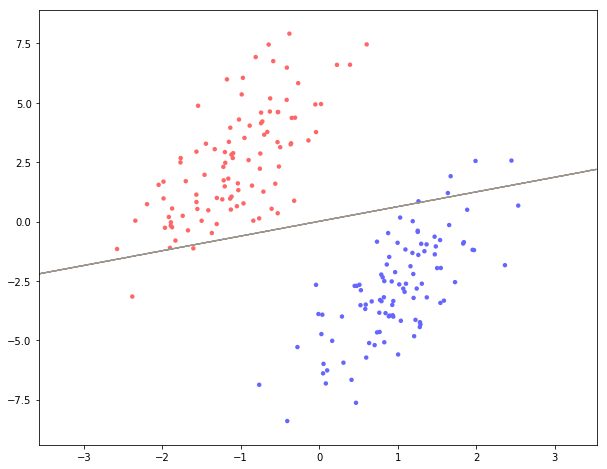

Iteration 1, w = [ 1.27913501 -1.72152007  0.05      ], cost: 6.56626


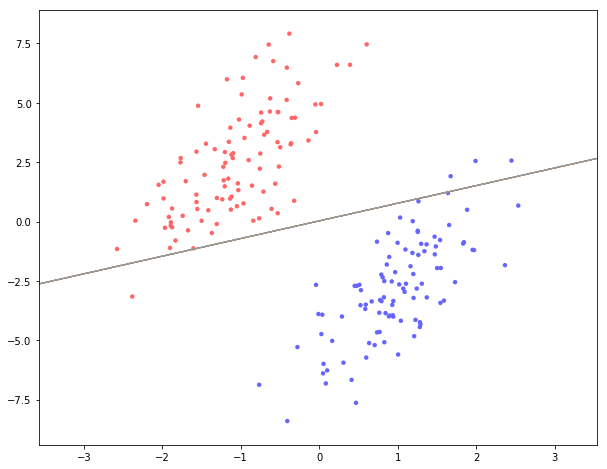

Iteration 2, w = [ 1.36411452 -1.61965492  0.07      ], cost: 4.76646


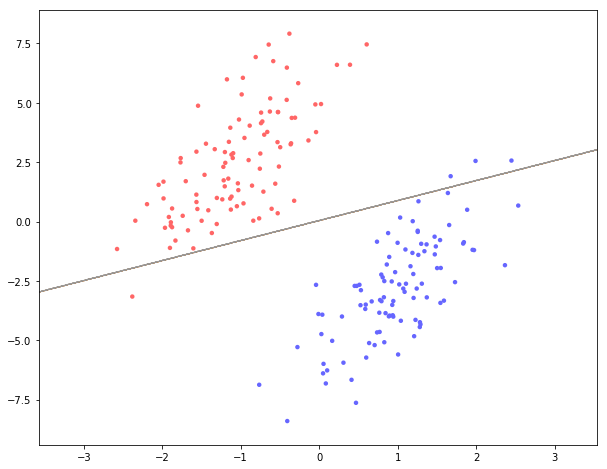

Iteration 3, w = [ 1.44909403 -1.51778976  0.09      ], cost: 2.96666


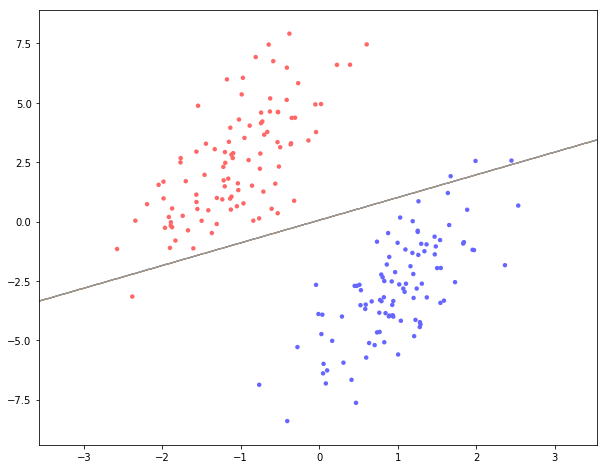

Iteration 4, w = [ 1.53407354 -1.41592461  0.11      ], cost: 1.39963


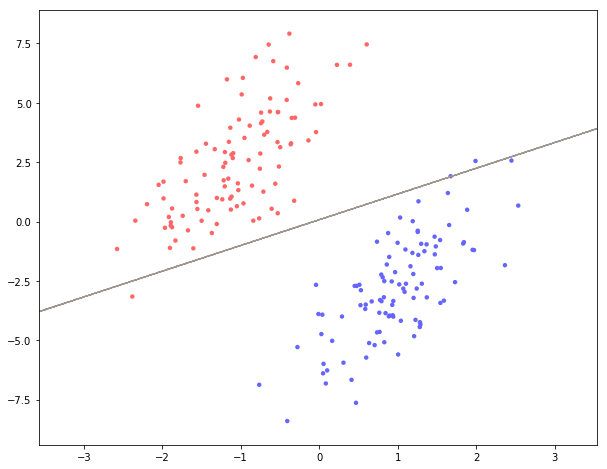

Iteration 5, w = [ 1.59455706 -1.33973238  0.12      ], cost: 0.67629


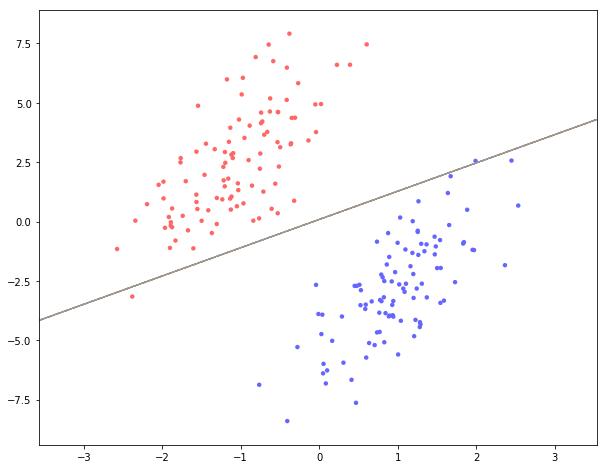

Iteration 6, w = [ 1.6382931  -1.28262952  0.12      ], cost: 0.26890


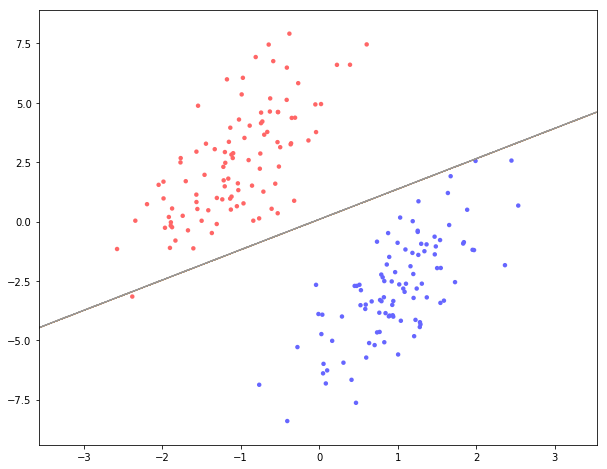

Iteration 7, w = [ 1.66211114 -1.25104606  0.11      ], cost: 0.10241


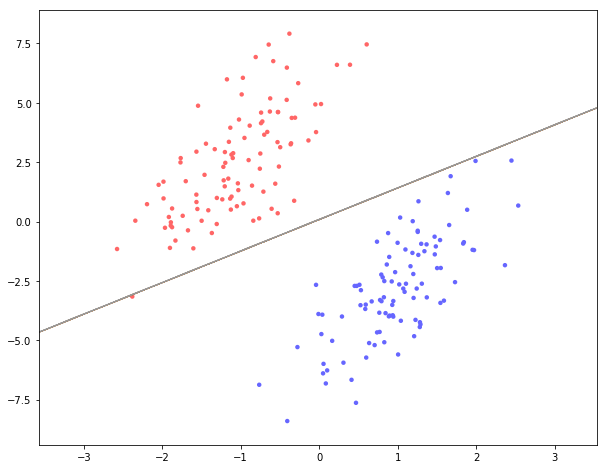

Iteration 8, w = [ 1.68592917 -1.21946259  0.1       ], cost: 0.00000


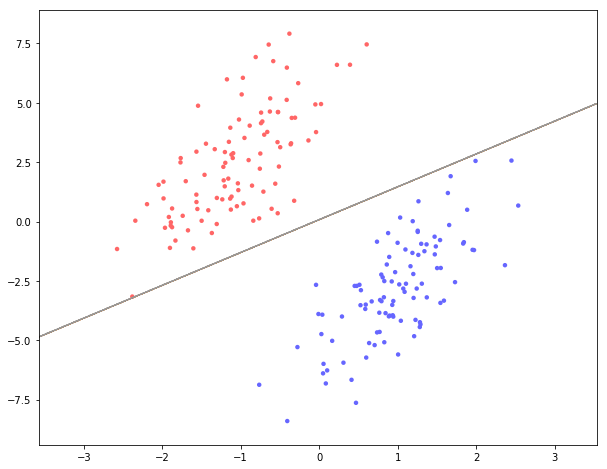

Iteration 9, w = [ 1.68592917 -1.21946259  0.1       ], cost: 0.00000


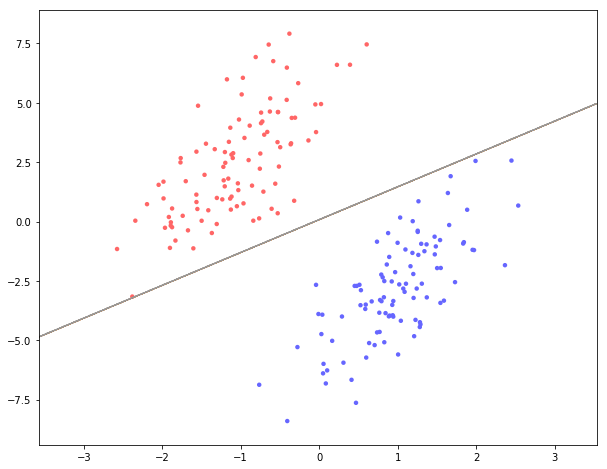

Converged at iteration 9, with cost = 0.000


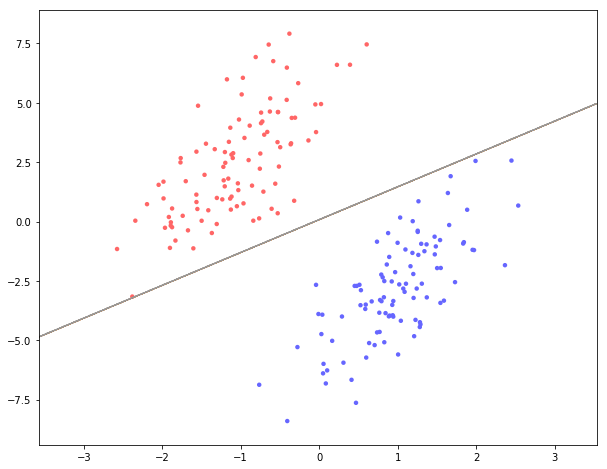

In [3]:
# Generate Training data and plot it
np.random.seed(0)

params_train = []

param = GaussianParam()
param.mean = [-1, 2.5]
param.cov = [[1, 5], [0, 1]]
param.N = 100
params_train.append(param)

param = GaussianParam()
param.mean = [1, -2.5]
param.cov = [[1, 5], [0, 1]]
param.N = 100
params_train.append(param)

X_train, y_train = Gaussian.generate(params_train, label_type='positive_negative')

clf = HandCraftedBinaryPerceptron()
clf.fit(X_train, y_train)

plot = Plot2D()
plot.scatter(X_train, y_train)
plot.classifierContour(X_train, y_train, clf)
plot.show()

### Demo 2.2.2. Perceptron of Scikit-Learn
----
The demo here shows how to generate 2 normal distributed groups of data, then classified by Scikit-learn built-in Perceptron algorithm.

#### Data Generation
Here we generate data as belows:
1. Generate 200 training data `X_train`, with corresponded label `y_train`
2. Generate 100 testing data `X_test`, with corresponded label `y_test`

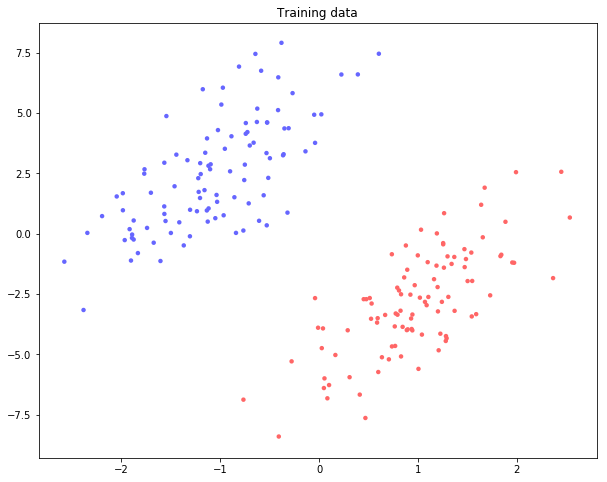

In [4]:
# Generate Training data
np.random.seed(0)

params_train = []

param = GaussianParam()
param.mean = [-1, 2.5]
param.cov = [[1, 5], [0, 1]]
param.N = 100
params_train.append(param)

param = GaussianParam()
param.mean = [1, -2.5]
param.cov = [[1, 5], [0, 1]]
param.N = 100
params_train.append(param)

X_train, y_train = Gaussian.generate(params_train)

plot = Plot2D()
plot.title('Training data')
plot.scatter(X_train, y_train)
plot.show()

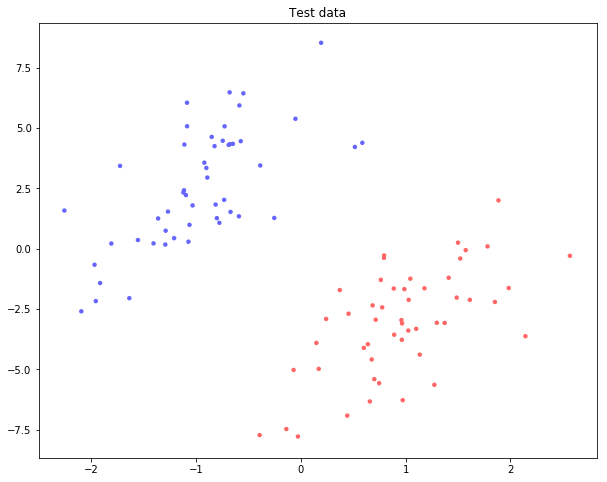

In [5]:
# Generate testing data
params_test = []

param = GaussianParam()
param.mean = [-1, 2.5]
param.cov = [[1, 5], [0, 1]]
param.N = 50
params_test.append(param)

param = GaussianParam()
param.mean = [1, -2.5]
param.cov = [[1, 5], [0, 1]]
param.N = 50
params_test.append(param)

X_test, y_test = Gaussian.generate(params_test)

plot = Plot2D()
plot.title('Test data')
plot.scatter(X_test, y_test)
plot.show()

#### Training and Predicting

Training a Perceptron model (which is built-in with Scikit-learn) with `X_train`, then predict the labels of `X_test`, with MCE computed.


c:\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Training data:


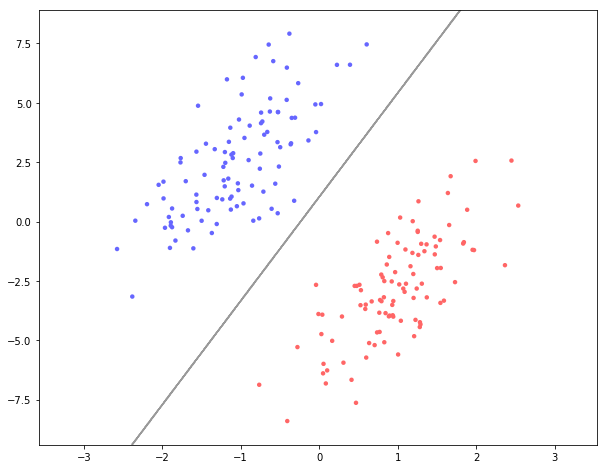

Testing data:
MCE = 0.000


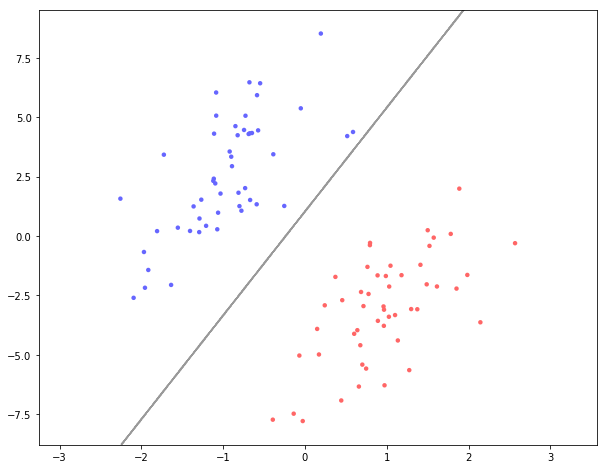

In [6]:
clfPLA = sklearn.linear_model.Perceptron()
clfPLA.fit(X_train, y_train)

y_test_predict = clfPLA.predict(X_test)

print("Training data:")
plot = Plot2D()
plot.scatter(X_train, y_train)
plot.classifierContour(X_train, y_train, clfPLA)
plot.show()

print("Testing data:")
print("MCE = %2.3f" % sklearn.metrics.zero_one_loss(y_test, y_test_predict))
plot = Plot2D()
plot.scatter(X_test, y_test)
plot.classifierContour(X_test, y_test, clfPLA)
plot.show()

## 2.3. Support Vector Machine (SVM)

### Demo 2.3.1. c-Support Vector Machine (c-SVC)
----
The demo here trains the model by SVM with `X_train`, then predict the testing data by `X_test`.

Notice that:
1. The number of support vectors is output via the attribute of `clfSVC.support_vectors_`
2. The support vectors are drawn via the wrapped function `mlfund.scatterSV`

Training data:
#SV = 3


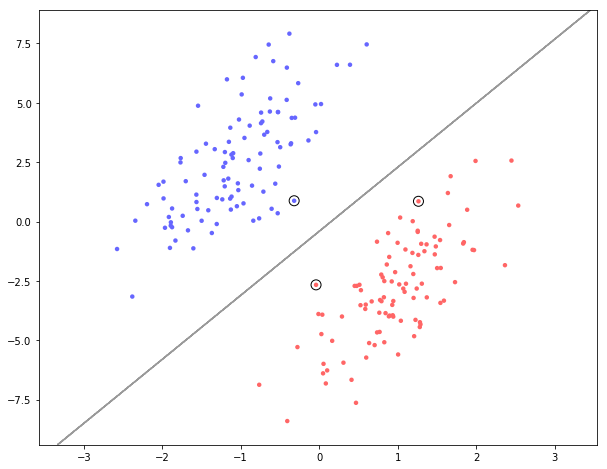

Testing data:
MCE = 0.000


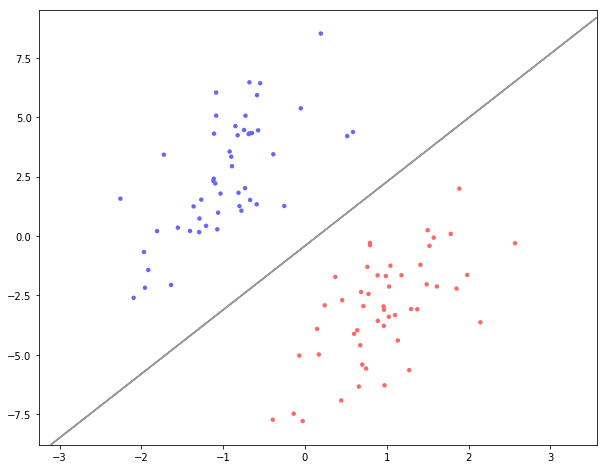

In [7]:
clfSVC = sklearn.svm.SVC(C=1, kernel='linear')
clfSVC.fit(X_train, y_train)

y_test_predict = clfSVC.predict(X_test)

print("Training data:")
print("#SV = %d" % len(clfSVC.support_vectors_))
plot = Plot2D()
plot.scatter(X_train, y_train)
plot.scatterCSVC(clfSVC)
plot.classifierContour(X_train, y_train, clfSVC)
plot.show()

print("Testing data:")
print("MCE = %2.3f" % sklearn.metrics.zero_one_loss(y_test, y_test_predict))
plot = Plot2D()
plot.scatter(X_test, y_test)
plot.classifierContour(X_test, y_test, clfSVC)
plot.show()

### Demo 2.3.2. c-Support Vector Machine (c-SVC) - A More Crowded Case
----
The demo here use the same settings of the c-SVM model, but learning from a more crowded data. One could adjust the value of `C` to observe the support vectors being relaxed by slack variables
* The larger `C`, the less support vectors (due to the more penalty of $\xi_i$), but the smaller margin size
* The smaller `C`, the more support vectors (due to the less penalty of $\xi_i$), but the larger margin size

D:\Github\tu-etp-ad1062\mlfund\dataset.py:42: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = numpy.random.multivariate_normal(param.mean, param.cov, param.N)
D:\Github\tu-etp-ad1062\mlfund\dataset.py:49: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X2 = numpy.random.multivariate_normal(param.mean, param.cov, param.N)


Training data:
#SV = 13


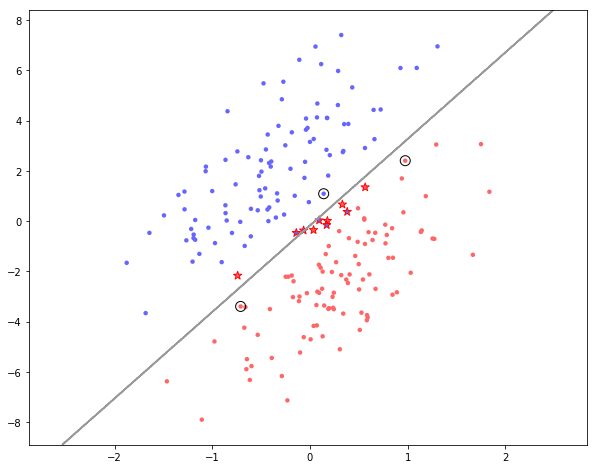

Testing data:
MCE = 0.050


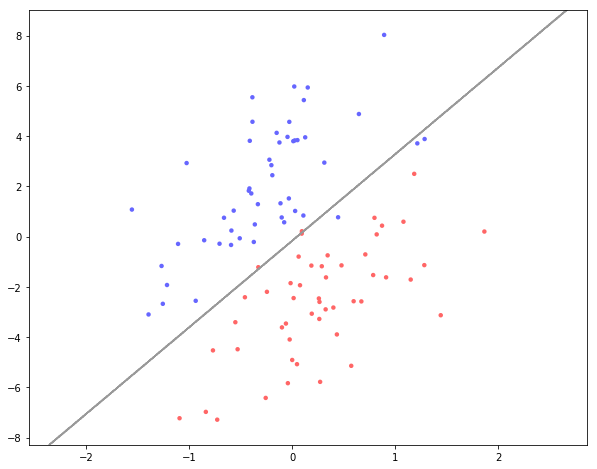

In [8]:
# Generate Training data and plot it
np.random.seed(0)

params_train = []

param = GaussianParam()
param.mean = [-0.3, 2]
param.cov = [[1, 5], [0, 1]]
param.N = 100
params_train.append(param)

param = GaussianParam()
param.mean = [0.3, -2]
param.cov = [[1, 5], [0, 1]]
param.N = 100
params_train.append(param)

X_train, y_train = Gaussian.generate(params_train)

# Generate testing data
params_test = []

param = GaussianParam()
param.mean = [-0.3, 2]
param.cov = [[1, 5], [0, 1]]
param.N = 50
params_test.append(param)

param = GaussianParam()
param.mean = [0.3, -2]
param.cov = [[1, 5], [0, 1]]
param.N = 50
params_test.append(param)

X_test, y_test = Gaussian.generate(params_test)
clfSVC = sklearn.svm.SVC(C=1000, kernel='linear')
clfSVC.fit(X_train, y_train)

y_test_predict = clfSVC.predict(X_test)

print("Training data:")
print("#SV = %d" % len(clfSVC.support_vectors_))
plot = Plot2D()
plot.scatter(X_train, y_train)
plot.scatterCSVC(clfSVC)
plot.classifierContour(X_train, y_train, clfSVC)
plot.show()

print("Testing data:")
print("MCE = %2.3f" % sklearn.metrics.zero_one_loss(y_test, y_test_predict))
plot = Plot2D()
plot.scatter(X_test, y_test)
plot.classifierContour(X_test, y_test, clfSVC)
plot.show()

